In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math

# Cleaning and exploring SIM dataset

In this notebook, we will explore the data in the SIM (Montreal Fire Safety Service) open dataset. The dataset contains information about incidents of fires in the city of Montreal, Canada. For more information regarding where this dataset is available please refer to the README file of this project. 

The following columns are included in the dataset:

INCIDENT_NBR: Identification of the event per year.

CREATION_DATE_TIME: Date and hour of the event.

DESCRIPTION_GROUPE: 6 categories : Incendies de bâtiments, Autres incendies, Sans incendie, Alarmes-incendie, Premiers répondants, Fausses alertes/annulations.

INCIDENT_TYPE_DESC: Incident type

CASERNE: Fire station number responsible of the territory where the event happened.

NOM_VILLE: City name.

NOM_ARROND: Neighbourhood name

DIVISION: SIM division number responsible of the territory where the event happened.

LONGITUDE,LATITUDE: Geo-position of the event (obfuscation à une intersection selon le référentiel géodésique WGS84)

NOMBRE_UNITES: Number of vehicules deploy as response of the event. Each unity consist of 3-5 firefighter.

In [5]:

sim = pd.read_csv('../data/donneesouvertes-interventions-sim.csv', parse_dates=["CREATION_DATE_TIME"])
sim.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE
0,14568,2015-02-08 14:24:12,Ac.véh./1R/s.v./ext/29B/D,1-REPOND,43,Montréal,Ahuntsic-Cartierville,3,2.0,294679.2,5045658.1,-73.629621,45.550763
1,15119,2015-02-10 04:09:39,Premier répondant,1-REPOND,21,Montréal,Saint-Léonard,8,1.0,297836.6,5050457.5,-73.589251,45.593988
2,7713,2015-01-19 19:15:56,Alarme privé ou locale,Alarmes-incendies,27,Montréal,Côte-des-Neiges-Notre-Dame-de-Grâce,4,4.0,295261.3,5039907.5,-73.622054,45.499025
3,7862,2015-01-20 08:32:39,Ac.véh./1R/s.v./ext/29B/D,1-REPOND,25,Montréal,Ville-Marie,6,2.0,299344.1,5039497.5,-73.569808,45.495379
4,8245,2015-01-21 10:47:00,Premier répondant,1-REPOND,45,Montréal,Mercier-Hochelaga-Maisonneuve,7,1.0,301892.1,5046652.7,-73.537249,45.559779


For this project, we are interested only in data for the last 5 years 2018 to 2022.

In [6]:
sim=sim[(sim["CREATION_DATE_TIME"] <= pd.Timestamp("2022-12-31")) & (sim["CREATION_DATE_TIME"] >= pd.Timestamp("2018-01-01"))]

Display number NULL values for each field

In [7]:
print(sim.isna().sum())

INCIDENT_NBR            0
CREATION_DATE_TIME      0
INCIDENT_TYPE_DESC      0
DESCRIPTION_GROUPE    122
CASERNE                 0
NOM_VILLE               0
NOM_ARROND              0
DIVISION                0
NOMBRE_UNITES         206
MTM8_X                  0
MTM8_Y                  0
LONGITUDE               0
LATITUDE                0
dtype: int64


Remove all null values if the threshold is less than 5% of the total number of samples

In [9]:
threshold = len(sim) * 0.05
cols_to_drop=sim.columns[sim.isna().sum() <= threshold]
sim.dropna(subset=cols_to_drop, inplace=True)

In [10]:
print(sim.isna().sum())

INCIDENT_NBR          0
CREATION_DATE_TIME    0
INCIDENT_TYPE_DESC    0
DESCRIPTION_GROUPE    0
CASERNE               0
NOM_VILLE             0
NOM_ARROND            0
DIVISION              0
NOMBRE_UNITES         0
MTM8_X                0
MTM8_Y                0
LONGITUDE             0
LATITUDE              0
dtype: int64


Creating two fields more, one to hold the month and another one for the year of a given incident

In [11]:
sim["month"] = sim["CREATION_DATE_TIME"].dt.month
sim["year"] =  sim["CREATION_DATE_TIME"].dt.year

In [12]:
sim.head()

,INCIDENT_NBR,CREATION_DATE_TIME,INCIDENT_TYPE_DESC,DESCRIPTION_GROUPE,CASERNE,NOM_VILLE,NOM_ARROND,DIVISION,NOMBRE_UNITES,MTM8_X,MTM8_Y,LONGITUDE,LATITUDE,month,year
1044,53919,2018-06-02 19:00:20,Premier répondant,1-REPOND,66,Montréal,Verdun,5,1.0,298731.2,5035729.9,-73.577602,45.461471,6,2018
1045,71185,2018-07-18 14:17:51,Acc. sans victime sfeu - ext.,SANS FEU,63,Dorval,Indéterminé,2,2.0,284675.2,5034451.5,-73.757285,45.449704,7,2018
1046,71620,2018-07-19 21:49:10,Ac.véh./1R/s.v./ext/29B/D,1-REPOND,49,Montréal,Ahuntsic-Cartierville,3,2.0,291154.3,5043803.3,-73.674713,45.534012,7,2018
1047,20807,2018-02-24 20:23:19,Ac.véh./1R/s.v./V.R./29B/D,1-REPOND,62,Dorval,Indéterminé,2,1.0,282730.8,5038425.7,-73.782322,45.485407,2,2018
1048,23316,2018-03-04 09:36:19,Premier répondant,1-REPOND,73,Montréal,Saint-Laurent,3,1.0,289408.3,5042450.5,-73.697026,45.521803,3,2018


In [70]:
incidents_per_group = sim.groupby("year")["DESCRIPTION_GROUPE"].value_counts()
incidents_per_group 

year  DESCRIPTION_GROUPE
2018  1-REPOND              78463
      SANS FEU              22007
      Alarmes-incendies     14406
      AUTREFEU               2950
      INCENDIE               1171
      FAU-ALER                 85
2019  1-REPOND              75351
      SANS FEU              23030
      Alarmes-incendies     14272
      AUTREFEU               2730
      INCENDIE               1205
      FAU-ALER                 87
2020  1-REPOND              45820
      SANS FEU              20401
      Alarmes-incendies     12429
      AUTREFEU               3030
      INCENDIE               1385
      FAU-ALER                 74
      NOUVEAU                   1
2021  1-REPOND              65043
      SANS FEU              19507
      Alarmes-incendies     12906
      AUTREFEU               2733
      INCENDIE               1245
      FAU-ALER                 55
      NOUVEAU                   1
2022  1-REPOND              71369
      SANS FEU              21863
      Alarmes-incendies

Let's explore the dataset. We will display the number of incidents by year by type. 

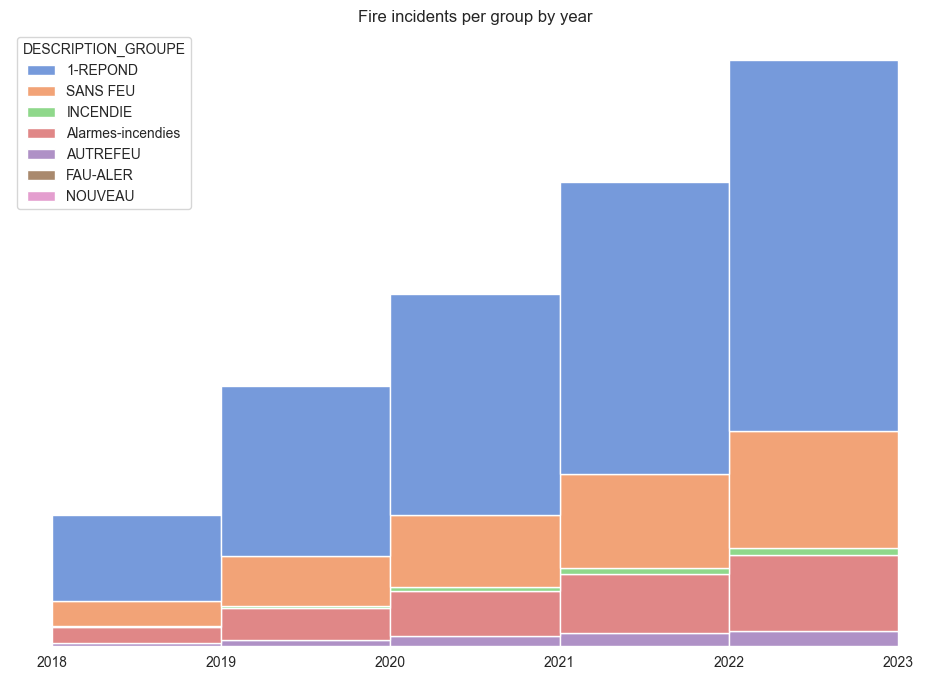

In [94]:
bin_edges = range(min(sim["year"]), max(sim["year"]) + 2) 

fig, ax = plt.subplots(figsize=(12, 8))
sns.set_style("white")
sns.set_palette("muted")
ax = sns.histplot(data=sim, x="year",hue="DESCRIPTION_GROUPE", cumulative=True, bins=bin_edges, legend=True, multiple='stack')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
sns.despine(ax=ax,top=True, right=True, left=True, bottom=True)
plt.title("Fire incidents per group by year")


# for rect in ax.patches:
#     x = rect.get_x() + rect.get_width() / 2
#     y = rect.get_height()
#     # ax.annotate(f"{y}", (x, y), ha="center", va="bottom")
#     ax.annotate(f"{y}",(x,y), ha="center", va="bottom")

plt.show()

Let's explore closely on incidents that are related to actual fires or fire alarm triggered. 

In [96]:
fires = sim[sim["DESCRIPTION_GROUPE"].isin(["INCENDIE", "Alarmes-incendies"])]
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74335 entries, 1055 to 925298
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   INCIDENT_NBR        74335 non-null  int64         
 1   CREATION_DATE_TIME  74335 non-null  datetime64[ns]
 2   INCIDENT_TYPE_DESC  74335 non-null  object        
 3   DESCRIPTION_GROUPE  74335 non-null  object        
 4   CASERNE             74335 non-null  int64         
 5   NOM_VILLE           74335 non-null  object        
 6   NOM_ARROND          74335 non-null  object        
 7   DIVISION            74335 non-null  int64         
 8   NOMBRE_UNITES       74335 non-null  float64       
 9   MTM8_X              74335 non-null  float64       
 10  MTM8_Y              74335 non-null  float64       
 11  LONGITUDE           74335 non-null  float64       
 12  LATITUDE            74335 non-null  float64       
 13  month               74335 non-null  int64 

Let's explore the data monthly to find any relevand relationships. 

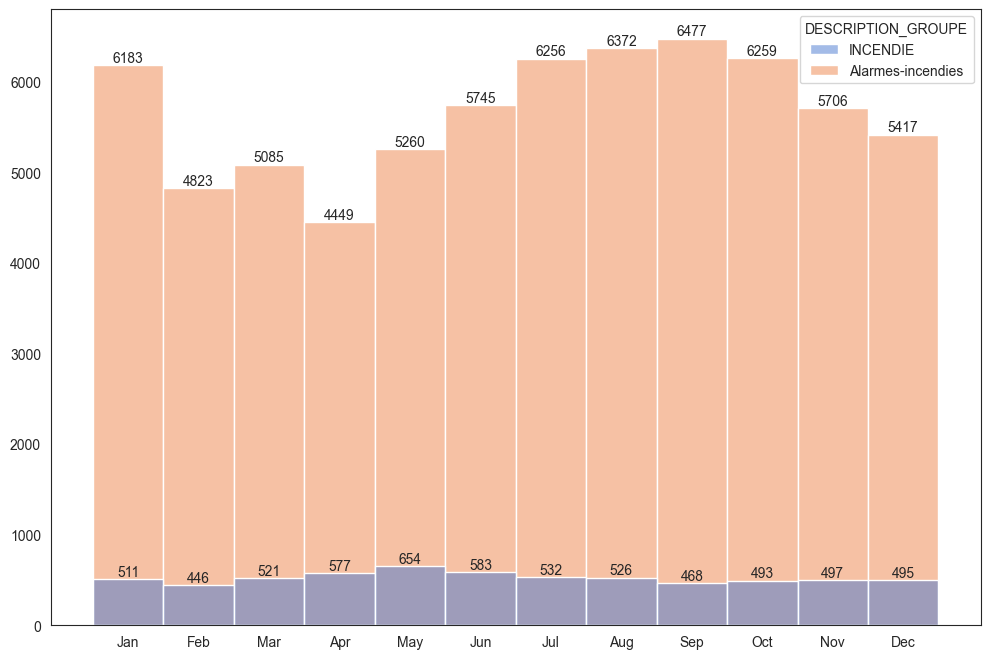

In [115]:
plt.figure(figsize=(12, 8))
sns.set_style("white")
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
bin_edges = range(1,14)
bin_midpoints = [(a + b) / 2 for a, b in zip(bin_edges[:-1], bin_edges[1:])]
hist_month = sns.histplot(data=fires, x="month", hue="DESCRIPTION_GROUPE",  bins=bin_edges, legend=True)
plt.xticks(ticks=bin_midpoints, labels=month_order)
hist_month.set(xlabel=None, ylabel=None)

# Add count labels to each bar
for rect in hist_month.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    hist_month.annotate(f"{y}", (x, y), ha='center', va='bottom')

plt.show()

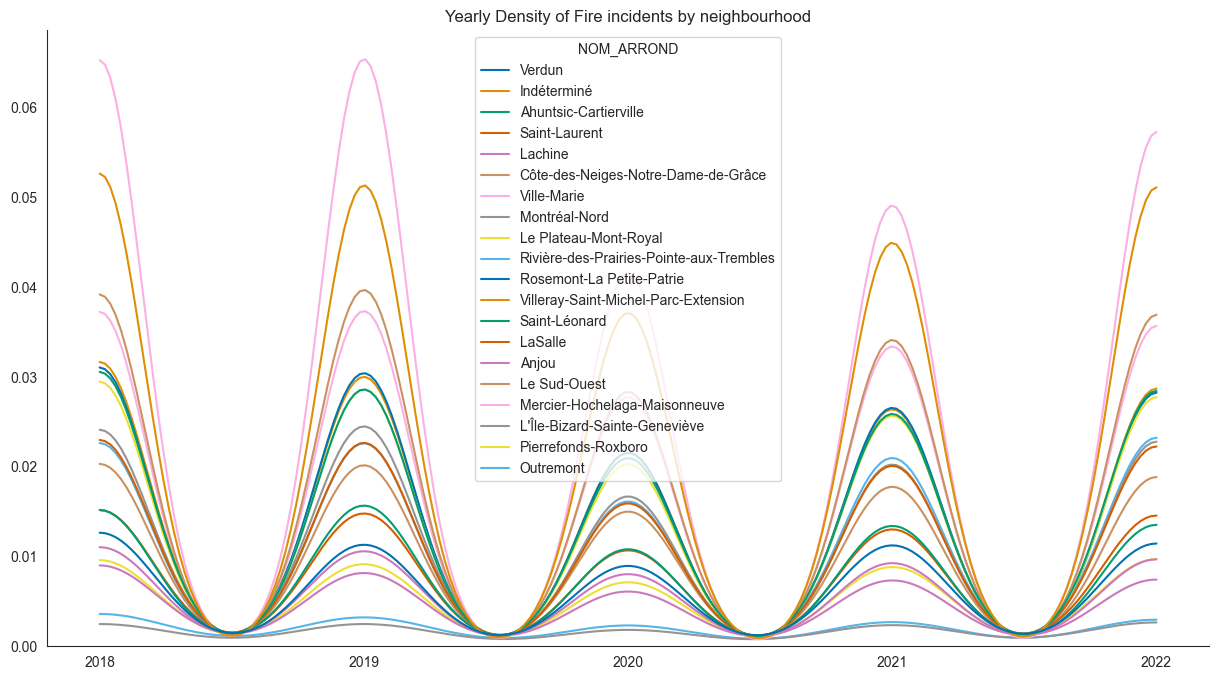

In [144]:
plt.figure(figsize=(15, 8))
kde=sns.kdeplot(data=sim,x="year", hue="NOM_ARROND", cut=0,palette='colorblind')
kde.set(xlabel=None, ylabel=None)
sns.despine(ax=kde,top=True, right=True)
plt.xticks(np.arange(2018, 2023, step=1))
plt.title("Yearly Density of Fire incidents by neighbourhood")
plt.show()

In [137]:
sim.value_counts("NOM_ARROND")

NOM_ARROND
Ville-Marie                                 60323
Indéterminé                                 52721
Côte-des-Neiges-Notre-Dame-de-Grâce         41267
Mercier-Hochelaga-Maisonneuve               39895
Villeray-Saint-Michel-Parc-Extension        33599
Rosemont-La Petite-Patrie                   33376
Ahuntsic-Cartierville                       32867
Le Plateau-Mont-Royal                       32249
Montréal-Nord                               27365
Rivière-des-Prairies-Pointe-aux-Trembles    26833
Saint-Laurent                               26486
Le Sud-Ouest                                23755
LaSalle                                     18648
Saint-Léonard                               18514
Verdun                                      15685
Lachine                                     13941
Pierrefonds-Roxboro                         13022
Anjou                                       11404
Outremont                                    5219
L'Île-Bizard-Sainte-Geneviève          

We can see that there is missing values for the field "NOM_ARROND". For now, we will not try to infer the neighbourhood for the missing values. but we have longitude and latitude values and we could infer the neighbourhood based on the location. 

We also corraborate the kde plot that shows Ville-Marie, Cote-des-Neiges-Notre-Dame-de-Grâce and Mercier-Hochelaga-Maisonneuve are the neighbourhoods with the highest number of incidents. 

In [163]:
montreal_map =gpd.read_file("../data/quartierreferencehabitation/QuartierReferenceHabitation.shp",encoding="utf-8")
montreal_map.head()

,no_qr,nom_qr,no_arr,nom_arr,nom_mun,geometry
0,53,Rivière-des-Prairies,33,Rivière-des-Prairies–Pointe-aux-Trembles,Montréal,"POLYGON ((301315.225 5056484.183, 301280.170 5..."
1,24,Beaurivage,22,Mercier–Hochelaga-Maisonneuve,Montréal,"POLYGON ((302930.947 5049983.135, 302927.054 5..."
2,23,Tétreaultville,22,Mercier–Hochelaga-Maisonneuve,Montréal,"POLYGON ((303517.518 5052488.647, 303663.588 5..."
3,22,Dupéré,22,Mercier–Hochelaga-Maisonneuve,Montréal,"POLYGON ((301904.048 5051627.574, 301901.648 5..."
4,25,Guybourg,22,Mercier–Hochelaga-Maisonneuve,Montréal,"POLYGON ((302483.979 5048458.998, 302526.607 5..."


In [167]:
montreal_map["nom_arr"].value_counts()

Mercier–Hochelaga-Maisonneuve               9
Rosemont–La Petite-Patrie                   7
Villeray–Saint-Michel–Parc-Extension        7
Côte-des-Neiges–Notre-Dame-de-Grâce         7
Ahuntsic-Cartierville                       6
Le Plateau-Mont-Royal                       6
Le Sud-Ouest                                5
Saint-Laurent                               5
Ville-Marie                                 4
Montréal-Nord                               4
Rivière-des-Prairies–Pointe-aux-Trembles    3
Verdun                                      3
Lachine                                     2
Pierrefonds-Roxboro                         2
Saint-Léonard                               2
LaSalle                                     2
Anjou                                       1
Outremont                                   1
L'Île-Bizard–Sainte-Geneviève               1
Name: nom_arr, dtype: int64

In [142]:
sim.value_counts("INCIDENT_TYPE_DESC").count()

136

# Cleaning and exploring crimes dataset

In [308]:
crime = pd.read_csv('actes-criminels.csv', parse_dates=["DATE"])
crime.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN


In [309]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254403 entries, 0 to 254402
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   CATEGORIE  254403 non-null  object        
 1   DATE       254403 non-null  datetime64[ns]
 2   QUART      254403 non-null  object        
 3   PDQ        254397 non-null  float64       
 4   X          211365 non-null  float64       
 5   Y          211365 non-null  float64       
 6   LONGITUDE  211365 non-null  float64       
 7   LATITUDE   211365 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 15.5+ MB


In [310]:
print(crime.isna().sum())

CATEGORIE        0
DATE             0
QUART            0
PDQ              6
X            43038
Y            43038
LONGITUDE    43038
LATITUDE     43038
dtype: int64


In [312]:
#Calculate the threshold. If missing data is less than 5%, we will drop it 
threshold = len(crime) * 0.05
print(threshold)

10568.25


Given that the missing data is related to the geolocation of the crime events, we will not be able to relate those crimes with an given area in Montreal. Therefore we opt to drop all missing data.

In [313]:
#many more than the threshold
crime.dropna(inplace=True)
print(crime.isna().sum())

CATEGORIE    0
DATE         0
QUART        0
PDQ          0
X            0
Y            0
LONGITUDE    0
LATITUDE     0
dtype: int64


Only keep data for the last 5 years

In [315]:
crime=crime[(crime["DATE"] <= pd.Timestamp("2022-12-31")) & (crime["DATE"] >= pd.Timestamp("2018-01-01"))]

Add new columns containing month and year of event

In [318]:
crime["CREATION_DATE_TIME_MONTH"] = crime["DATE"].dt.month
crime["CREATION_DATE_TIME_YEAR"] =  crime["DATE"].dt.year

/var/folders/p7/cshrl10s47n6p2hd0yjwjjsr0000gn/T/ipykernel_62108/1759463456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime["CREATION_DATE_TIME_MONTH"] = crime["DATE"].dt.month
/var/folders/p7/cshrl10s47n6p2hd0yjwjjsr0000gn/T/ipykernel_62108/1759463456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime["CREATION_DATE_TIME_YEAR"] =  crime["DATE"].dt.year


In [319]:
crime.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,CREATION_DATE_TIME_MONTH,CREATION_DATE_TIME_YEAR
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,9,2018
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,4,2018
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,9,2018
11,Introduction,2018-08-28,soir,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,8,2018
12,Introduction,2018-01-10,jour,30.0,294670.696005,5.047695e+06,-73.629772,45.569087,1,2018


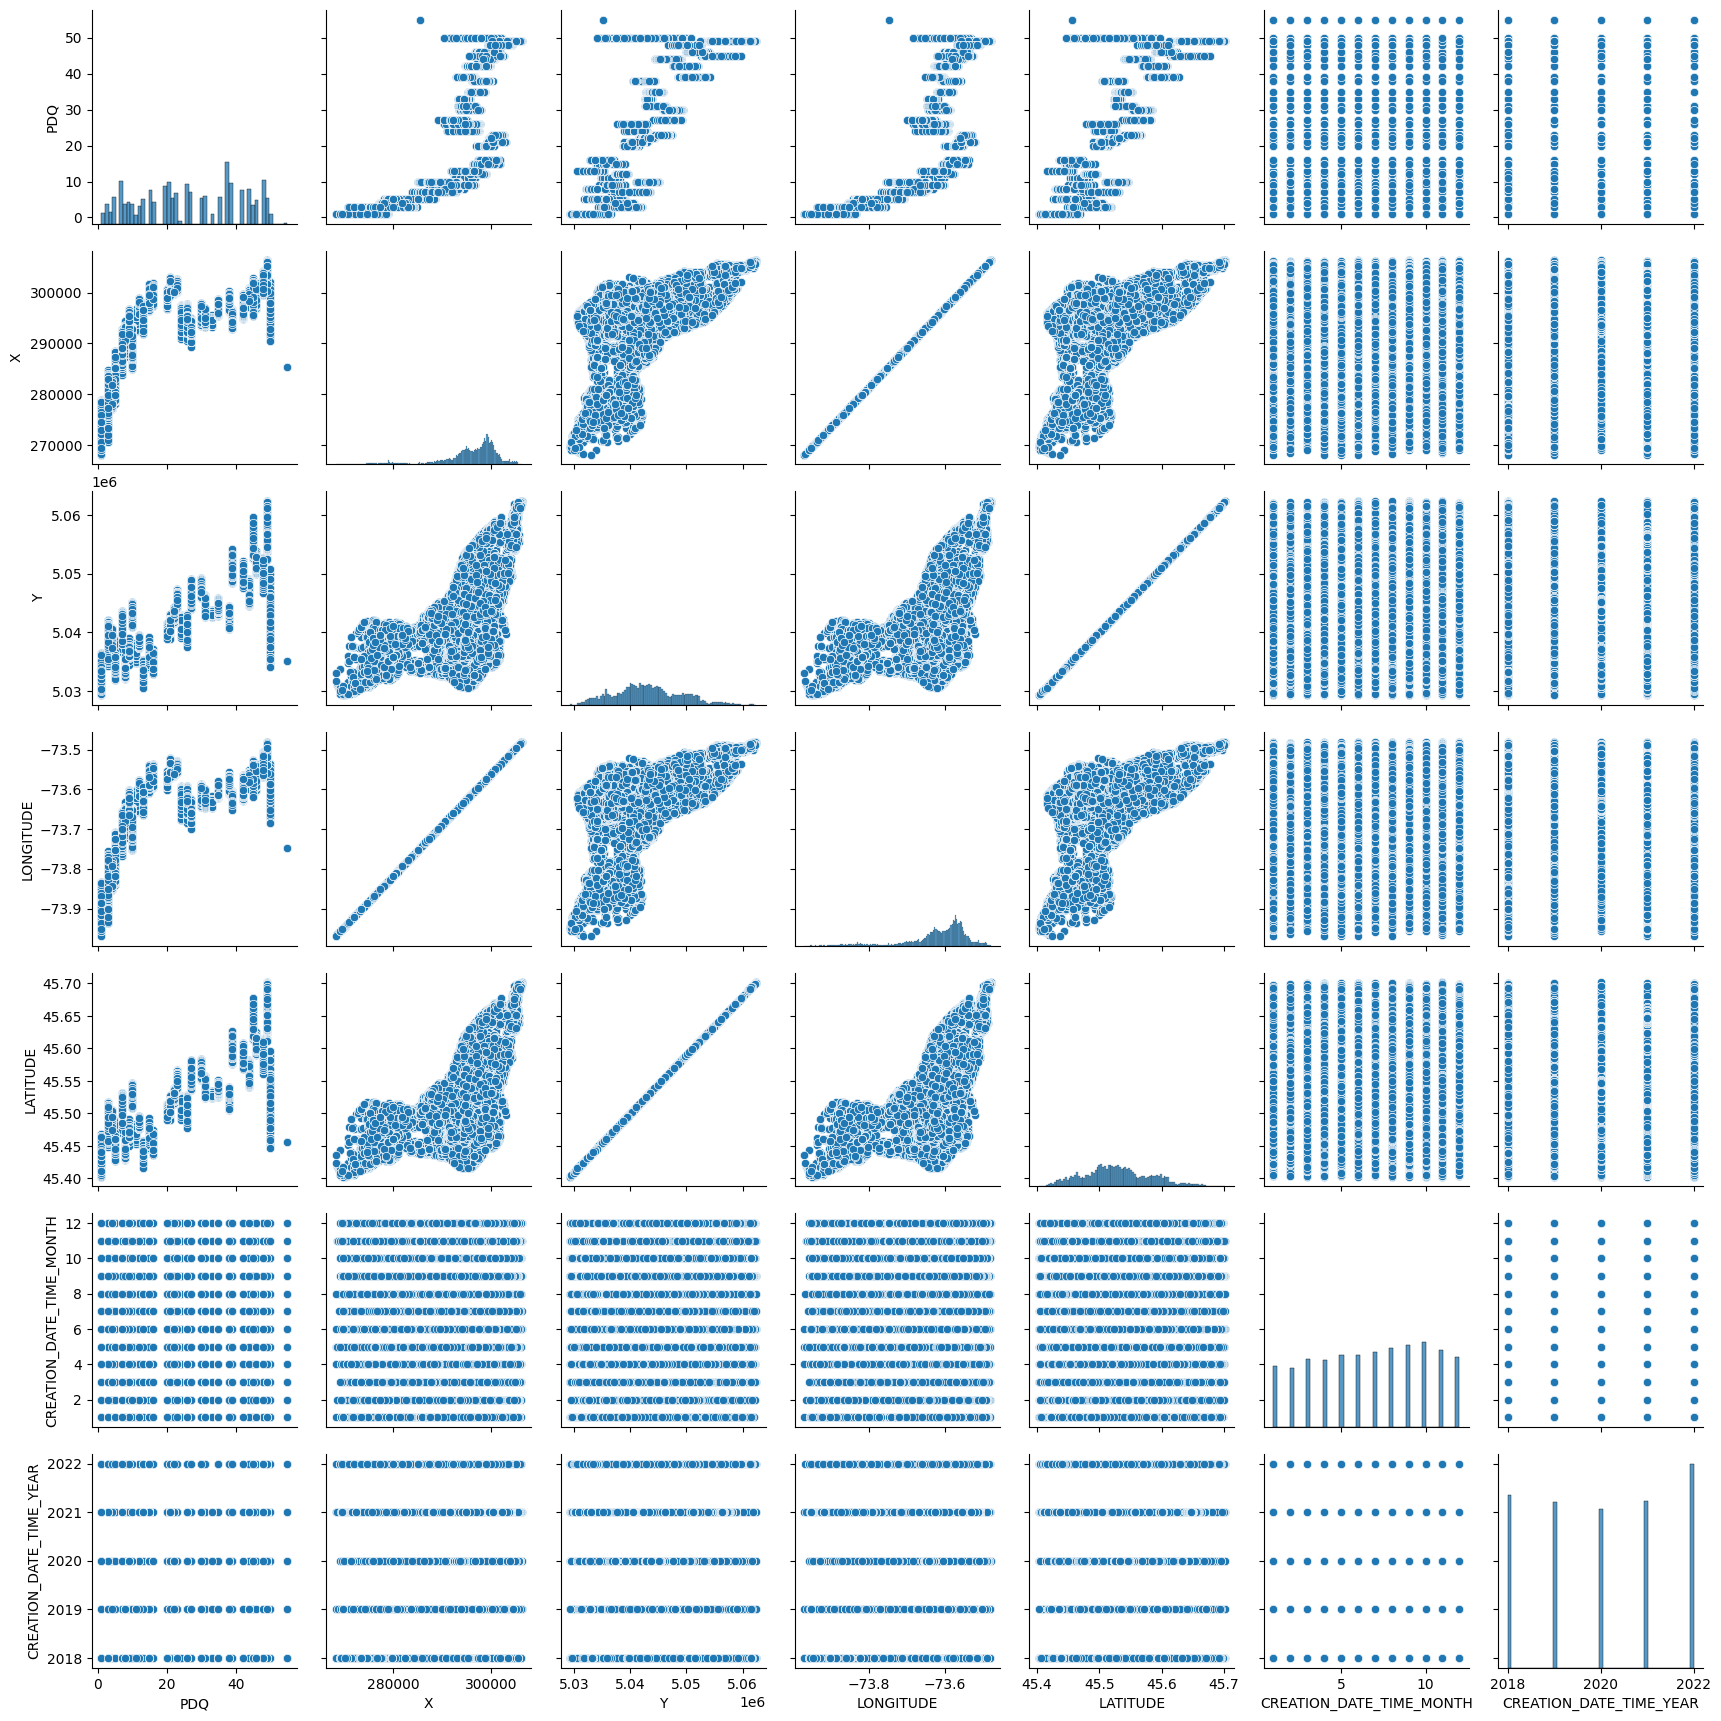

In [320]:
sns.pairplot(data=crime)

Let's check if there are some correlation

In [321]:
crime.corr()

/var/folders/p7/cshrl10s47n6p2hd0yjwjjsr0000gn/T/ipykernel_62108/2959462628.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  crime.corr()


,PDQ,X,Y,LONGITUDE,LATITUDE,CREATION_DATE_TIME_MONTH,CREATION_DATE_TIME_YEAR
PDQ,1.000000,0.644716,0.799942,0.644223,0.800559,-0.016031,0.000613
X,0.644716,1.000000,0.461187,0.999999,0.462979,-0.004014,0.000462
Y,0.799942,0.461187,1.000000,0.460344,0.999998,-0.016671,-0.003023
LONGITUDE,0.644223,0.999999,0.460344,1.000000,0.462137,-0.003987,0.000466
LATITUDE,0.800559,0.462979,0.999998,0.462137,1.000000,-0.016678,-0.003027
CREATION_DATE_TIME_MONTH,-0.016031,-0.004014,-0.016671,-0.003987,-0.016678,1.000000,0.028660
CREATION_DATE_TIME_YEAR,0.000613,0.000462,-0.003023,0.000466,-0.003027,0.028660,1.000000


Let's explore the number of crimes per year in Montreal

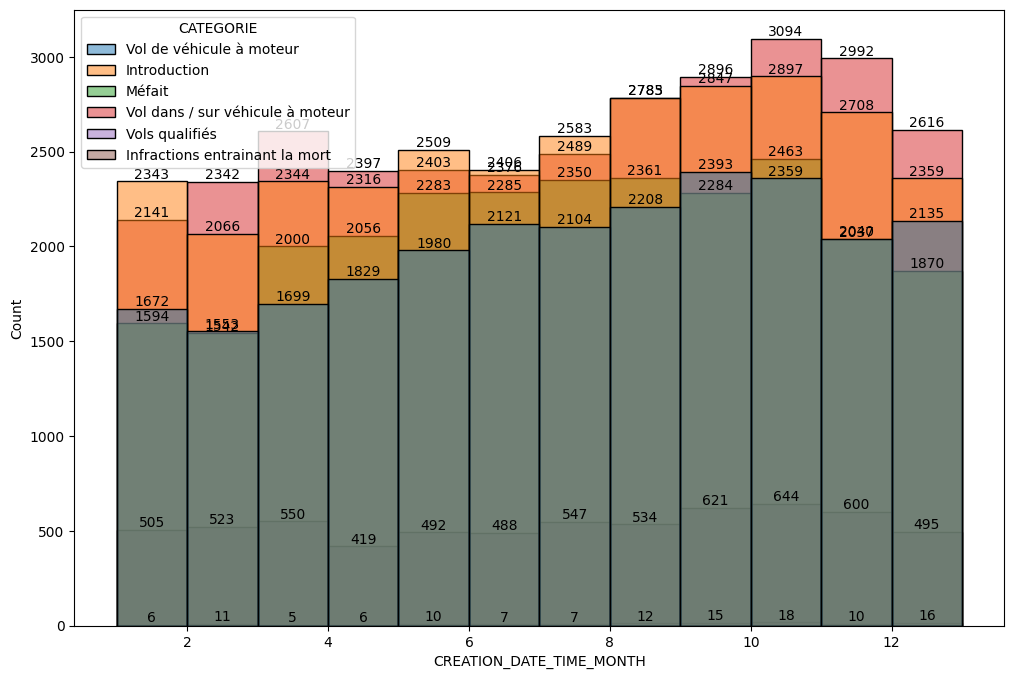

In [323]:
plt.figure(figsize=(12, 8))
# Calculate the bin edges for each month
bin_edges_month = range(min(crime["CREATION_DATE_TIME_MONTH"]), max(crime["CREATION_DATE_TIME_MONTH"]) +2)
hist_month_crime = sns.histplot(data=crime, x="CREATION_DATE_TIME_MONTH", hue="CATEGORIE",bins=bin_edges_month)

# Add count labels to each bar
for rect in hist_month_crime.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    hist_month_crime.annotate(f"{y}", (x, y), ha='center', va='bottom')

plt.show()

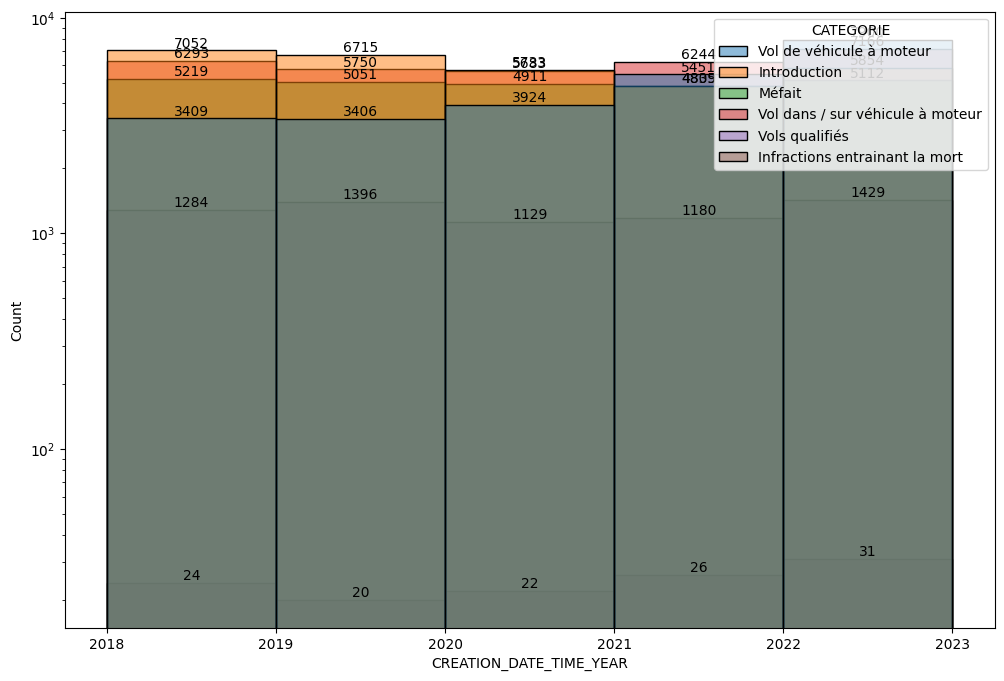

In [324]:
plt.figure(figsize=(12, 8))
# Calculate the bin edges for each year
bin_edges = range(min(crime["CREATION_DATE_TIME_YEAR"]), max(crime["CREATION_DATE_TIME_YEAR"]) + 2) # Add 2 to include the upper edge of the last year

# Plot the histogram with custom bin edges
hist_year_crime = sns.histplot(data=crime, x="CREATION_DATE_TIME_YEAR",hue="CATEGORIE", bins=bin_edges)
hist_year_crime.set_yscale('log')

# Add count labels to each bar
for rect in hist_year_crime.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    hist_year_crime.annotate(f"{y}", (x, y), ha='center', va='bottom')

plt.show()

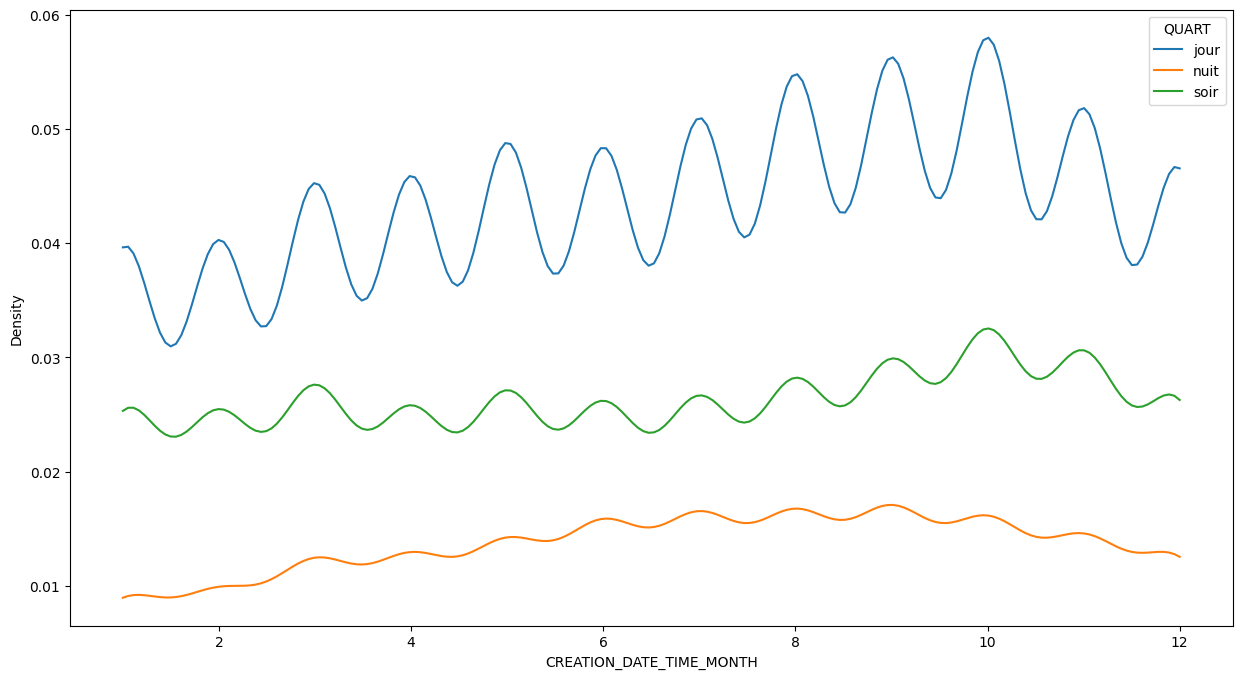

In [328]:
plt.figure(figsize=(15, 8))
sns.kdeplot(data=crime,x="CREATION_DATE_TIME_MONTH", hue="QUART", cut=0)
plt.show()

# Cleaning and exploring fire stations dataset

In [330]:
casernes= pd.read_csv('casernes.csv', parse_dates=["DATE_DEBUT","DATE_FIN"])
casernes.head()

,CASERNE,NO_CIVIQUE,RUE,LATITUDE,LONGITUDE,ARRONDISSEMENT,VILLE,DATE_DEBUT,DATE_FIN,MTM8_X,MTM8_Y
0,3,256,rue Young,45.493454,-73.560172,LE SUD-OUEST,NaN,2015-01-01 07:00:00,NaT,300097.0,5039283.0
1,15,1255,rue de la Sucrerie,45.484419,-73.560917,LE SUD-OUEST,NaN,2015-01-01 07:00:00,NaT,300038.0,5038279.0
2,23,523,place Saint-Henri,45.477820,-73.585257,LE SUD-OUEST,NaN,2015-01-01 07:00:00,NaT,298134.6,5037547.3
3,33,6040,boulevard Monk,45.457841,-73.595450,LE SUD-OUEST,NaN,2015-01-01 07:00:00,NaT,297335.0,5035328.0
4,9,8100,boulevard Saint-Michel,45.563748,-73.610169,VILLERAY-SAINT-MICHEL-PARC-EXTENSION,NaN,2019-05-06 07:00:00,NaT,296200.0,5047099.0


In [331]:
casernes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CASERNE         68 non-null     int64         
 1   NO_CIVIQUE      68 non-null     int64         
 2   RUE             68 non-null     object        
 3   LATITUDE        68 non-null     float64       
 4   LONGITUDE       68 non-null     float64       
 5   ARRONDISSEMENT  54 non-null     object        
 6   VILLE           14 non-null     object        
 7   DATE_DEBUT      68 non-null     datetime64[ns]
 8   DATE_FIN        1 non-null      datetime64[ns]
 9   MTM8_X          68 non-null     float64       
 10  MTM8_Y          68 non-null     float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(3)
memory usage: 6.0+ KB


In [332]:
print(casernes.isna().sum())

CASERNE            0
NO_CIVIQUE         0
RUE                0
LATITUDE           0
LONGITUDE          0
ARRONDISSEMENT    14
VILLE             54
DATE_DEBUT         0
DATE_FIN          67
MTM8_X             0
MTM8_Y             0
dtype: int64


In [333]:
casernes["ARRONDISSEMENT"].fillna("unknown", inplace=True)
casernes["VILLE"].fillna("unknown", inplace=True)
casernes["DATE_FIN"].fillna(pd.Timestamp.today().date(), inplace=True)
print(casernes.isna().sum())

CASERNE           0
NO_CIVIQUE        0
RUE               0
LATITUDE          0
LONGITUDE         0
ARRONDISSEMENT    0
VILLE             0
DATE_DEBUT        0
DATE_FIN          0
MTM8_X            0
MTM8_Y            0
dtype: int64


In [334]:
casernes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CASERNE         68 non-null     int64         
 1   NO_CIVIQUE      68 non-null     int64         
 2   RUE             68 non-null     object        
 3   LATITUDE        68 non-null     float64       
 4   LONGITUDE       68 non-null     float64       
 5   ARRONDISSEMENT  68 non-null     object        
 6   VILLE           68 non-null     object        
 7   DATE_DEBUT      68 non-null     datetime64[ns]
 8   DATE_FIN        68 non-null     object        
 9   MTM8_X          68 non-null     float64       
 10  MTM8_Y          68 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 6.0+ KB


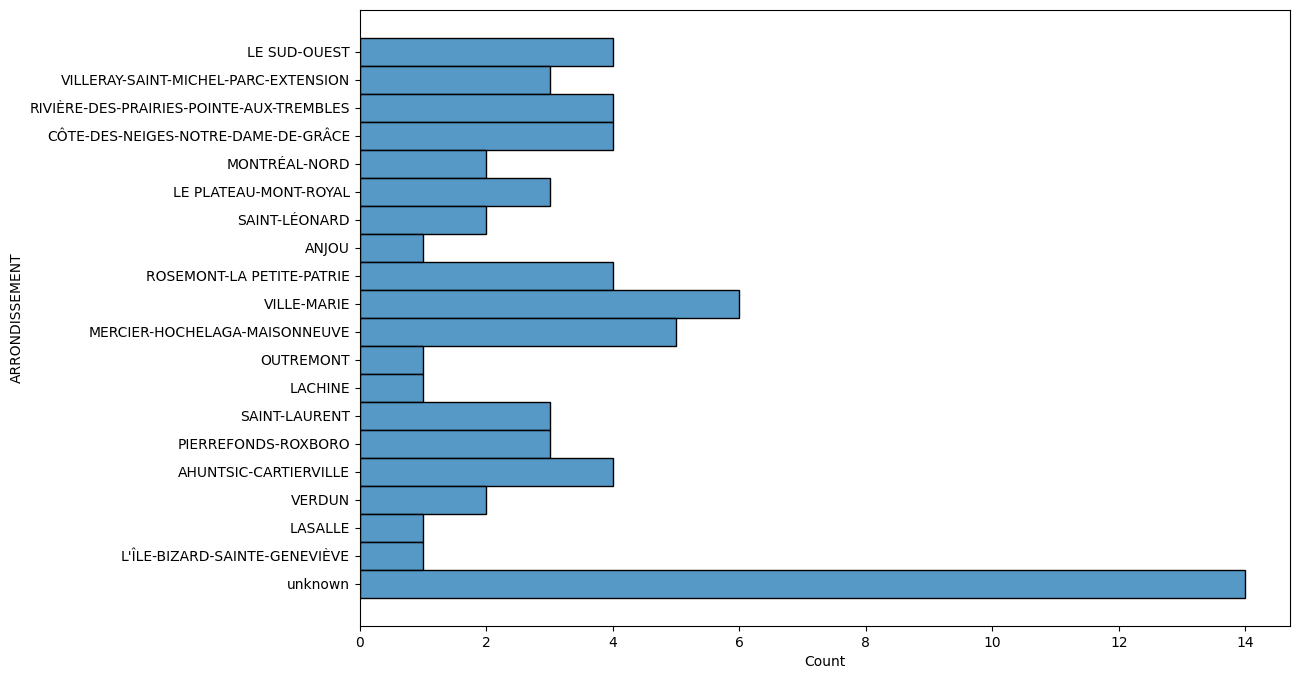

In [337]:
plt.figure(figsize=(12, 8))
hist_year_casernes = sns.histplot(data=casernes, y="ARRONDISSEMENT", bins=bin_edges)
plt.show()

# Cleaning and exploration property assessment

In [360]:
unites= pd.read_csv('uniteevaluationfonciere.csv')
unites.head()

,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,NOM_RUE,SUITE_DEBUT,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,LETTRE_DEBUT,LETTRE_FIN,LIBELLE_UTILISATION,CATEGORIE_UEF,MATRICULE83,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT,NO_ARROND_ILE_CUM
0,3116438,10145,10145,avenue de l' Esplanade (MTL),NaN,50,2.0,1.0,1949,1000,NaN,NaN,Logement,Régulier,9145-90-7246-7-000-0000,419.0,121.0,REM23
1,1027986,964,966,boulevard Saint-Joseph Est (MTL),NaN,50,3.0,5.0,1931,1000,NaN,NaN,Logement,Régulier,9843-12-9674-2-000-0000,307.0,619.0,REM21
2,1039285,4150,4150,chemin de Trafalgar (MTL),NaN,50,2.0,1.0,1964,1000,NaN,NaN,Logement,Régulier,9639-93-1058-8-000-0000,271.0,285.0,REM19
3,1039286,620,636,rue Cathcart (MTL),NaN,50,12.0,NaN,1934,6000,NaN,NaN,Immeuble à bureaux,Régulier,9940-43-5648-9-000-0000,1482.0,13981.0,REM19
4,1039287,56,56,rue Belvedere Circle (MTL),NaN,50,2.0,1.0,1927,1000,NaN,NaN,Logement,Régulier,9639-93-1415-0-000-0000,1349.0,492.0,REM19


In [361]:
unites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504564 entries, 0 to 504563
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID_UEV               504564 non-null  int64  
 1   CIVIQUE_DEBUT        504564 non-null  int64  
 2   CIVIQUE_FIN          504564 non-null  int64  
 3   NOM_RUE              504564 non-null  object 
 4   SUITE_DEBUT          128029 non-null  object 
 5   MUNICIPALITE         504564 non-null  int64  
 6   ETAGE_HORS_SOL       454846 non-null  float64
 7   NOMBRE_LOGEMENT      458589 non-null  float64
 8   ANNEE_CONSTRUCTION   504564 non-null  int64  
 9   CODE_UTILISATION     504564 non-null  int64  
 10  LETTRE_DEBUT         3248 non-null    object 
 11  LETTRE_FIN           6336 non-null    object 
 12  LIBELLE_UTILISATION  504564 non-null  object 
 13  CATEGORIE_UEF        504564 non-null  object 
 14  MATRICULE83          504564 non-null  object 
 15  SUPERFICIE_TERRAI

In [355]:
print(unites.isna().sum())

ID_UEV                      0
CIVIQUE_DEBUT               0
CIVIQUE_FIN                 0
NOM_RUE                     0
SUITE_DEBUT            376535
MUNICIPALITE                0
ETAGE_HORS_SOL          49718
NOMBRE_LOGEMENT         45975
ANNEE_CONSTRUCTION          0
CODE_UTILISATION            0
LETTRE_DEBUT           501316
LETTRE_FIN             498228
LIBELLE_UTILISATION         0
CATEGORIE_UEF               0
MATRICULE83                 0
SUPERFICIE_TERRAIN          1
SUPERFICIE_BATIMENT    146896
NO_ARROND_ILE_CUM           0
dtype: int64


In [348]:
threshold = len(unites) * 0.05
cols_to_drop=unites.columns[unites.isna().sum() <= threshold]
unites.dropna(inplace=True)

In [349]:
print(unites.isna().sum())

ID_UEV                 0
CIVIQUE_DEBUT          0
CIVIQUE_FIN            0
NOM_RUE                0
SUITE_DEBUT            0
MUNICIPALITE           0
ETAGE_HORS_SOL         0
NOMBRE_LOGEMENT        0
ANNEE_CONSTRUCTION     0
CODE_UTILISATION       0
LETTRE_DEBUT           0
LETTRE_FIN             0
LIBELLE_UTILISATION    0
CATEGORIE_UEF          0
MATRICULE83            0
SUPERFICIE_TERRAIN     0
SUPERFICIE_BATIMENT    0
NO_ARROND_ILE_CUM      0
dtype: int64


In [356]:
unites.corr()

/var/folders/p7/cshrl10s47n6p2hd0yjwjjsr0000gn/T/ipykernel_62108/91298841.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  unites.corr()


,ID_UEV,CIVIQUE_DEBUT,CIVIQUE_FIN,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,ANNEE_CONSTRUCTION,CODE_UTILISATION,SUPERFICIE_TERRAIN,SUPERFICIE_BATIMENT
ID_UEV,1.000000,0.012565,0.012536,-0.123133,-0.313335,-0.069229,0.039954,0.048806,0.005591,0.017808
CIVIQUE_DEBUT,0.012565,1.000000,1.000000,0.041869,0.023620,0.010857,0.765979,0.744778,0.045739,0.009135
CIVIQUE_FIN,0.012536,1.000000,1.000000,0.041893,0.023844,0.011047,0.766002,0.744820,0.045770,0.009174
MUNICIPALITE,-0.123133,0.041869,0.041893,1.000000,0.010811,0.033302,-0.012148,-0.001733,-0.014618,0.014479
ETAGE_HORS_SOL,-0.313335,0.023620,0.023844,0.010811,1.000000,0.472394,0.025091,0.039395,0.025857,0.021756
NOMBRE_LOGEMENT,-0.069229,0.010857,0.011047,0.033302,0.472394,1.000000,0.058574,0.025556,0.163235,0.079683
ANNEE_CONSTRUCTION,0.039954,0.765979,0.766002,-0.012148,0.025091,0.058574,1.000000,0.699480,0.088565,0.018356
CODE_UTILISATION,0.048806,0.744778,0.744820,-0.001733,0.039395,0.025556,0.699480,1.000000,0.088926,0.050543
SUPERFICIE_TERRAIN,0.005591,0.045739,0.045770,-0.014618,0.025857,0.163235,0.088565,0.088926,1.000000,0.060332
SUPERFICIE_BATIMENT,0.017808,0.009135,0.009174,0.014479,0.021756,0.079683,0.018356,0.050543,0.060332,1.000000


In [357]:
unites.value_counts("CATEGORIE_UEF")

CATEGORIE_UEF
Régulier          318484
Condominium       186079
Infrastructure         1
dtype: int64

In [358]:
unites.value_counts("LIBELLE_UTILISATION")

LIBELLE_UTILISATION
Logement                                                                                           457164
Espace de terrain non aménagé et non exploité (sauf l'exploitation non commerciale de la forêt)     11409
Stationnement intérieur (condo)                                                                      8524
Immeuble commercial                                                                                  4425
Stationnement extérieur (condo)                                                                      2323
                                                                                                    ...  
Service de réparation et de rembourrage de meubles                                                      1
Industrie de la confection à forfait de vêtements pour femmes et filles                                 1
Industrie de la chaussure                                                                               1
Industrie de l'équipement 

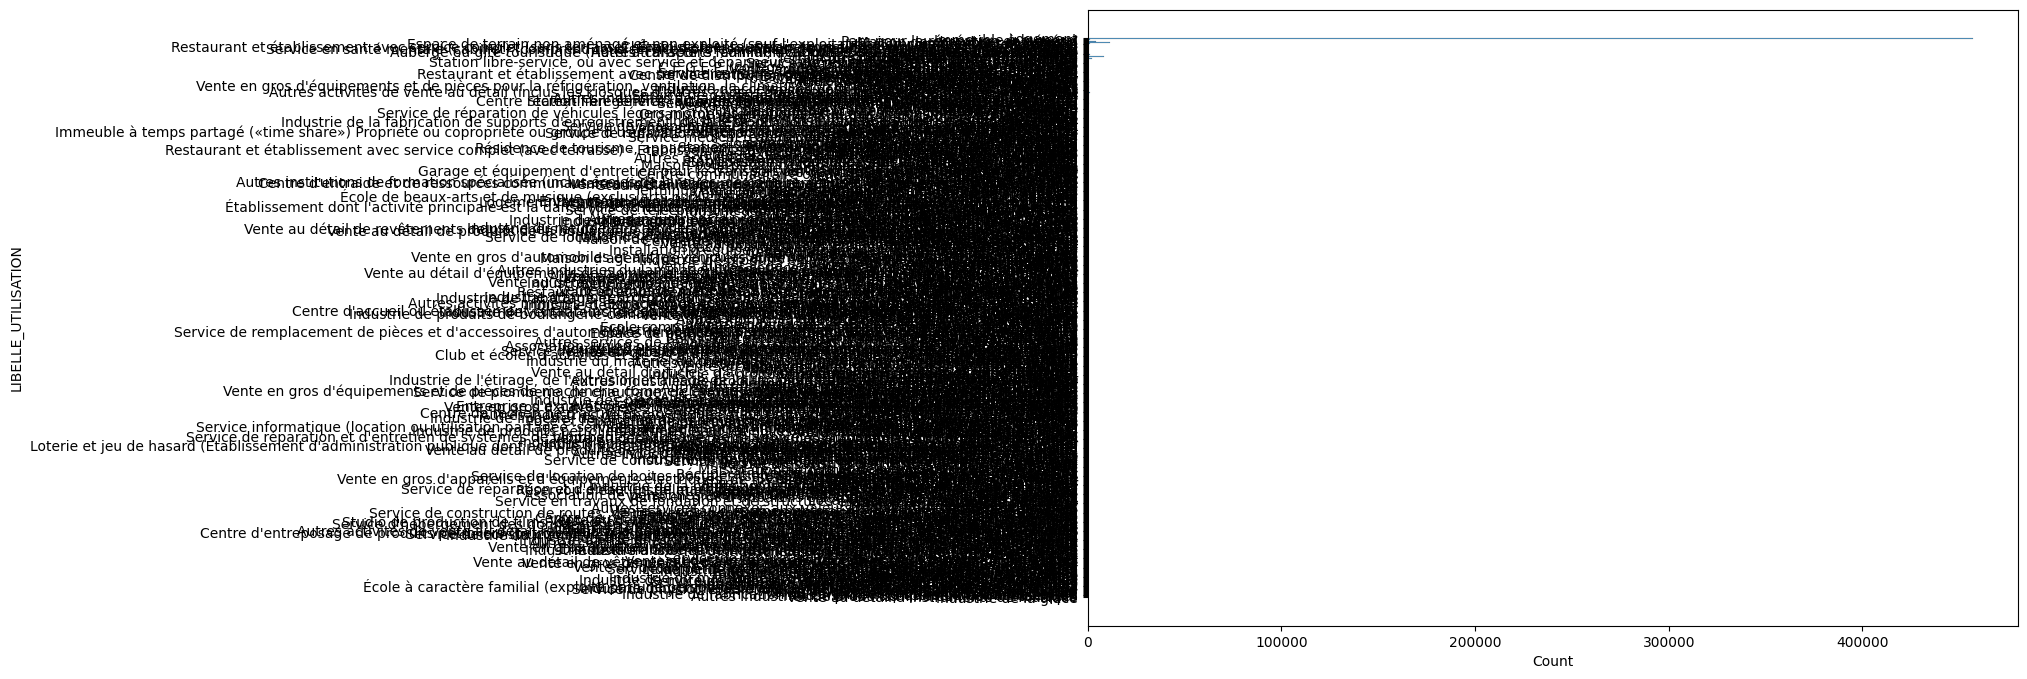

In [359]:
plt.figure(figsize=(12, 8))
hist_year_unites = sns.histplot(data=unites, y="LIBELLE_UTILISATION", bins=bin_edges)
plt.show()